In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.optimize
import mpmath
import uncertainties as unc
from uncertainties import ufloat
from uncertainties import unumpy as unp

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (6,4)

pd.set_option('display.max_rows', 2000)

In [190]:
# Tenma 72-2590 Multimeter has error for DCV of +-(0.5%).

no_nitrogen = pd.read_csv("nonitrogen.csv")
nitrogen = pd.read_csv("nitrogen.csv")

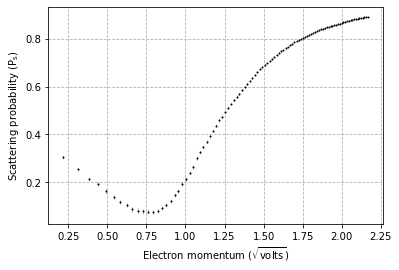

In [225]:
# Extract voltages from dataframes and convert to numpy arrays
V = no_nitrogen["V"].to_numpy()
V_s = no_nitrogen["V_s"].to_numpy()
V_p = no_nitrogen["V_p"].to_numpy()

V_s_star = nitrogen["V_s"].to_numpy()
V_p_star = nitrogen["V_p"].to_numpy()

# Calculate errors on all measurements.
dV_s = V_s*(0.5/100)
dV_p = V_p*(0.5/100)

dV_s_star = V_s_star*(0.5/100)
dV_p_star = V_p_star*(0.5/100)

# Define voltages with uncertainty for propagation by the Uncertainties package.
u_V_s = unp.uarray(V_s, dV_s)
u_V_p = unp.uarray(V_p, dV_p)

u_V_s_star = unp.uarray(V_s_star, dV_s_star)
u_V_p_star = unp.uarray(V_p_star, dV_p_star)

# Define shield resistor resistance R_s and plate resistor resistance R_p in ohms.
R_s = 100
R_p = 10000

# Calculate current through each resistor, with uncertainty. '_star' denotes that the xenon gas was frozen out by nitrogen.
u_I_s = u_V_s/100
u_I_p = u_V_p/10000

u_I_s_star = u_V_s_star/100
u_I_p_star = u_V_p_star/10000

# Calculate scattering probability, with uncertainty. 
u_P_s = 1 - (u_I_p * u_I_s_star)/(u_I_s * u_I_p_star)

# Calculate electron momentum, with uncertainty.
u_rho_e = (V - u_V_s)**(1/2)

# Plot scattering probability against electron momentum.
x = unp.nominal_values(u_rho_e)
y = unp.nominal_values(u_P_s)
xerr0 = unp.std_devs(u_rho_e)
yerr0 = unp.std_devs(u_P_s)

plt.scatter(x, y, color = "black", s = 1, zorder = 5)
plt.errorbar(x, y, yerr0, xerr0, fmt = "none", ecolor = "gray", elinewidth = 0.6)
plt.grid(linestyle = "--")
plt.xlabel(r"Electron momentum $(\sqrt{\mathrm{volts}})$")
plt.ylabel("Scattering probability ($\mathrm{P_s}$)")

plt.savefig("Scattering probability.pdf", bbox_inches = "tight")

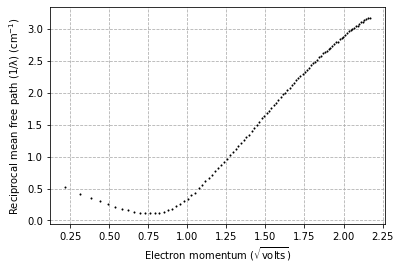

In [224]:
def mean_free_path(l, P_s):
    return -l/(unp.log(1 - P_s))

my_lambda = mean_free_path(0.7, u_P_s)

plt.scatter(x, 1/unp.nominal_values(my_lambda), color = "black", s = 1, zorder = 5)
plt.errorbar(x, 1/unp.nominal_values(my_lambda), unp.std_devs(1/my_lambda), xerr,
             fmt = "none", ecolor = "gray", elinewidth = 0.6)

plt.grid(linestyle = "--")
plt.xlabel(r"Electron momentum $(\sqrt{\mathrm{volts}})$")
plt.ylabel("Reciprocal mean free path ($\mathrm{1/\lambda}$) ($\mathrm{cm^{-1}}$)")

plt.savefig("Mean free path.pdf", bbox_inches = "tight")

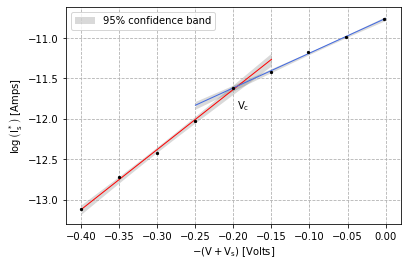

In [230]:
# Define line for use in creating linear fit with scipy curve_fit().
def line(x, m, c):
    return m * x + c

# Extension.
extension = pd.read_csv("extension.csv")

# Extract voltages from extension dataframe.
V_ex = extension["V"].to_numpy()
V_s_star_ex = extension["V_s"].to_numpy()
V_p_star_ex = extension["V_p"].to_numpy()

# Calculate errors on all measurements.
dV_s_star_ex = V_s_star_ex*(0.5/100)
dV_p_star_ex = V_p_star_ex*(0.5/100)

# Define voltages with uncertainty for propagation by the Uncertainties package.
u_V_s_star_ex = unp.uarray(V_s_star_ex, dV_s_star_ex)
u_V_p_star_ex = unp.uarray(V_p_star_ex, dV_p_star_ex)

# Calculate current through each resistor, with uncertainty.
u_I_s_star_ex = u_V_s_star_ex/100
u_I_p_star_ex = u_V_p_star_ex/10000

##############################
# PLOT LEFT-MOST LINEAR FIT #
##############################

x_fit0 = np.linspace(-0.4, -0.15, 1000)

x = -(V_ex + u_V_s_star_ex)
y = unp.log(u_I_s_star_ex)

nom_x = unp.nominal_values(x)
nom_y = unp.nominal_values(y)

xerr = unp.std_devs(x)
yerr = unp.std_devs(y)

# Generate array of optimum line parameters popt, where popt[0] = m, popt[1] = c, and parameter covariance matrix pcov.
popt0, pcov0 = scipy.optimize.curve_fit(line, nom_x[4:], nom_y[4:])

# Initialise correlated system of values for propagation handling by the Uncertainties package.
m0, c0 = unc.correlated_values(popt0, pcov0)
        
y_fit0 = line(x_fit0, m0, c0)
nom_y0 = unp.nominal_values(y_fit0)
std_y0 = unp.std_devs(y_fit0)
        
# Plot linear fit line.
plt.plot(x_fit0, nom_y0, color = "red", linewidth = 1)
        
# Plot 95% confidence interval, making sure to include covariance since fit parameters are obviously correlated.
lower_bound0 = nom_y0 - 2*std_y0
upper_bound0 = nom_y0 + 2*std_y0
plt.fill_between(x_fit0, lower_bound0, upper_bound0,
                 color = "black", alpha = 0.15, linewidth = 0, label = "95% confidence band")

#############################
# PLOT RIGHT-MOST LINEAR FIT #
#############################

x_fit1 = np.linspace(-0.25, 0, 1000)

# Generate array of optimum line parameters popt, where popt[0] = m, popt[1] = c, and parameter covariance matrix pcov.
popt1, pcov1 = scipy.optimize.curve_fit(line, nom_x[0:4], nom_y[0:4])

# Initialise correlated system of values for propagation handling by the Uncertainties package.
m1, c1 = unc.correlated_values(popt1, pcov1)
        
y_fit1 = line(x_fit1, m1, c1)
nom_y1 = unp.nominal_values(y_fit1)
std_y1 = unp.std_devs(y_fit1)
        
# Plot left-most linear fit line.
plt.plot(x_fit1, nom_y1, color = "royalblue", linewidth = 1)
        
# Plot 95% confidence interval, making sure to include covariance since fit parameters are obviously correlated.
lower_bound1 = nom_y1 - 2*std_y1
upper_bound1 = nom_y1 + 2*std_y1
plt.fill_between(x_fit1, lower_bound1, upper_bound1, color = "black", alpha = 0.15, linewidth = 0)

plt.scatter(nom_x, nom_y, color = "black", s = 5, zorder = 5)
plt.errorbar(nom_x, nom_y, yerr, xerr, fmt = "none", ecolor = "gray", elinewidth = 0.6)
plt.grid(linestyle = "--")
plt.xlabel(r"$\mathrm{-(V + V_s)}$ [Volts]")
plt.ylabel(r"$\mathrm{\log{\left(I_s^*\right)}}$ [Amps]")

text0 = r"$\mathrm{V_c}$"
ax = plt.gca()
plt.text(0.51, 0.53, text0, transform = ax.transAxes)
plt.legend()

plt.savefig("Extension.pdf", bbox_inches = "tight")

In [235]:
# Finding V_bar.
def get_V_bar(m):
    return 3/(2*m)

u_V_bar = get_V_bar(m0)

# Finding V_c as intersection of our two best-fit lines.
def get_V_c(m0, m1, c0, c1):
    return np.abs((c1-c0)/(m0-m1))

u_V_c = get_V_c(m0, m1, c0, c1)

print(u_V_bar, u_V_c)

0.202+/-0.006 0.194+/-0.011


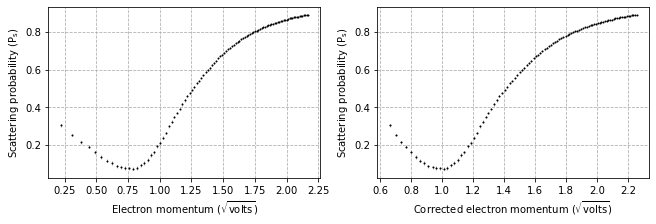

In [234]:
# Plot with extension corrections.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3), constrained_layout = True)

# Calculate corrected electron momentum, with uncertainty.
u_rho_e_corrected = (V - u_V_s + u_V_c + u_V_bar)**(1/2)

# Plot scattering probability against electron momentum.
x = unp.nominal_values(u_rho_e)
y = unp.nominal_values(u_P_s)
xerr0 = unp.std_devs(u_rho_e)
yerr0 = unp.std_devs(u_P_s)

ax1.scatter(x, y, color = "black", s = 1, zorder = 5)
ax1.errorbar(x, y, yerr0, xerr0, fmt = "none", ecolor = "gray", elinewidth = 0.6)
ax1.grid(linestyle = "--")
ax1.set_xlabel(r"Electron momentum $(\sqrt{\mathrm{volts}})$")
ax1.set_ylabel("Scattering probability ($\mathrm{P_s}$)")

#############################################################################################

# Plot scattering probability against corrected electron momentum.
x = unp.nominal_values(u_rho_e_corrected)
y = unp.nominal_values(u_P_s)
xerr0 = unp.std_devs(u_rho_e_corrected)
yerr0 = unp.std_devs(u_P_s)

ax2.scatter(x, y, color = "black", s = 1, zorder = 5)
ax2.errorbar(x, y, yerr0, xerr0, fmt = "none", ecolor = "gray", elinewidth = 0.6)
ax2.grid(linestyle = "--")
ax2.set_xlabel(r"Corrected electron momentum $(\sqrt{\mathrm{volts}})$")
ax2.set_ylabel("Scattering probability ($\mathrm{P_s}$)")

plt.savefig("Corrected scattering probability.pdf", bbox_inches = "tight")

Text(0, 0.5, '$\\mathrm{I_p^*}$ (Amps)')

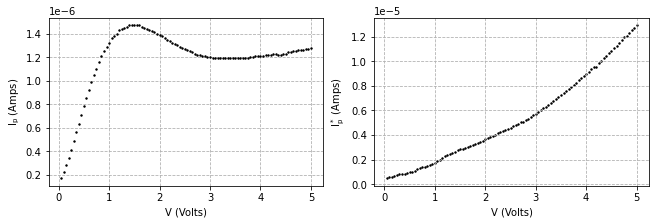

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3), constrained_layout = True)

ax1.scatter(V, unp.nominal_values(u_I_p), color = "black", s = 2, zorder = 5)
ax1.grid(linestyle = "--")
ax1.set_xlabel("V (Volts)")
ax1.set_ylabel(r"$\mathrm{I_p}$ (Amps)")

ax2.scatter(V, unp.nominal_values(u_I_p_star), color = "black", s = 2)
ax2.grid(linestyle = "--")
ax2.set_xlabel("V (Volts)")
ax2.set_ylabel(r"$\mathrm{I_p^*}$ (Amps)")